In [3]:
import pandas as pd
from typing import List, Union
import matplotlib.pyplot as plt
import numpy as np

In [33]:
def get_feature_activations_for_agent(feature: Union[str, int], agent_log_file: str):
    """
    Parses the agent log file and returns a list of the number of tokens in which the feature is active for the given agent.
    Note: The file contains logs from multiple runs on the same agent, hence the activations of the feature will be return for all runs.
    """
    with open(agent_log_file, 'r') as f:
        lines = f.readlines()
    # parses inspect log file and returns a list of feature activations for the given agent

def get_cooperation_rates(results_csv_file: str, agents: tuple=None) -> List[float]:
    """
    Parses the results CSV file and returns the cooperation rate
    for the given agent across multiple runs.

    columns: Round, A_0 Move, A_0 Payoff, A_0 Cumulative, A_0 Reason,
             A_1 Move, A_1 Payoff, A_1 Cumulative, A_1 Reason, ...
    """
    results = pd.read_csv(results_csv_file)
    if 'Experiment_id' not in results.columns:
        # add experiment id column if not present
        results['Experiment_id'] = 0
    if agents is None:
        agents = ['A_0', 'A_1']
    # parse the CSV to extract cooperation rates per run
    cooperation_rates = [{} for experiment_id in results['Experiment_id'].unique()]
    for experiment_id in results['Experiment_id'].unique():
        experiment_results = results[results['Experiment_id'] == experiment_id]
        # calculate cooperation rate for each agent
        for agent in agents:
            cooperation_rates[experiment_id][agent] = np.array((experiment_results[f'{agent} Move'] == 'Stay Silent'), dtype=int)
            cooperation_rates[experiment_id][agent] = cooperation_rates[experiment_id][agent].cumsum()
            for i, coop_value in enumerate(cooperation_rates[experiment_id][agent]):
                cooperation_rates[experiment_id][agent][i] = coop_value / (i + 1)  # calculate cooperation rate 
    return cooperation_rates

In [ ]:
def bootstrap_confidence_interval(data, num_samples=10000, confidence_level=0.95, random_seed=None):
    """
    Computes the confidence interval for the mean of the data using bootstrap resampling.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    data = np.array(data)
    n = len(data)
    boot_means = [np.mean(np.random.choice(data, size=n, replace=True)) for _ in range(num_samples)]

    alpha = 1 - confidence_level
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper


def plot_statistic(statistic_name: str,
                   data: list[list[float]],
                   use_bootstrap: bool = True,
                   num_bootstrap_samples: int = 10000,
                   confidence_level: float = 0.95,
                   save_path: str = None):
    """
    Plots the mean ± error for each index across multiple experiments.

    Parameters:
    - statistic_name: Name for plot title.
    - data: 2D list (shape: [num_experiments][num_features_or_rounds])
    - use_bootstrap: Whether to use bootstrap CI instead of standard deviation.
    - save_path: Optional file path to save the plot.
    """

    data = np.array(data)  # Shape: (num_experiments, num_features_or_rounds)
    num_points = data.shape[1]

    means = np.mean(data, axis=0)
    if use_bootstrap:
        ci_lowers, ci_uppers = [], []
        for i in range(num_points):
            lower, upper = bootstrap_confidence_interval(data[:, i],
                                                         num_samples=num_bootstrap_samples,
                                                         confidence_level=confidence_level)
            ci_lowers.append(means[i] - lower)
            ci_uppers.append(upper - means[i])
        yerr = [ci_lowers, ci_uppers]
    else:
        stds = np.std(data, axis=0, ddof=1)
        yerr = [stds, stds]

    x = np.arange(num_points)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(x, means, yerr=yerr, fmt='-o', capsize=5, color='blue', ecolor='red', elinewidth=1.5)

    ax.set_title(f"{statistic_name} (Mean ± {'95% CI' if use_bootstrap else 'Std'})")
    ax.set_xlabel("Feature / Round Index")
    ax.set_ylabel("Value")
    ax.set_xticks(x)

    plt.grid(True, linestyle='--', alpha=0.6)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    else:
        plt.show()

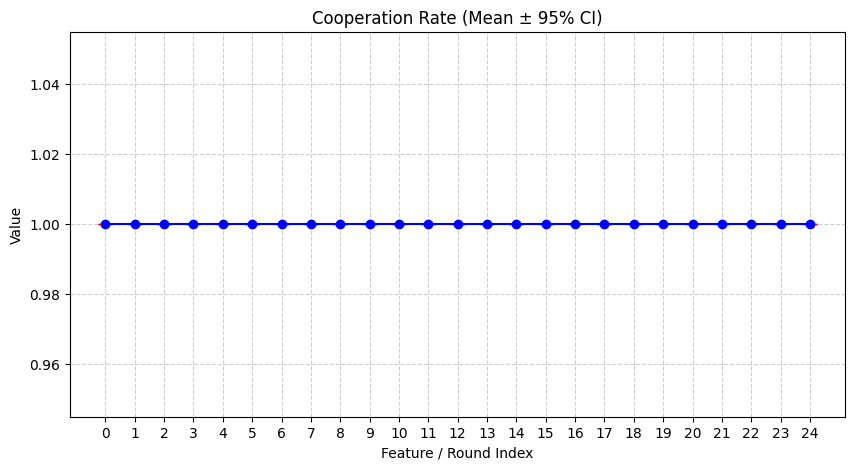

In [35]:
plot_statistic(statistic_name="Cooperation Rate",
                   data=np.array(get_cooperation_rates("./results/results_prompt_50_20250309-185047.csv")[0]['A_0'][:25]).reshape(1, -1),
                   use_bootstrap=True,
                   save_path="cooperation_rate.png")